[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/center4ml/Workshops/blob/2023_1/Day1/2_autoencoders.ipynb)

# Autoencoders

Type of neural network which typically aims to learn efficient representations (efficient coding) of the data.
Usually autoencoders are trained in an unsupervised manner.


### Applications
1. Anomaly detection
2. Pretraining
3. Dimensionality reduction
4. Denoising

**Reconstruction**
![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

### Some more examples of autoencoders:
- [convolutional](https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac)
- [time series data](https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [tabular data](https://medium.com/@vkansal/credit-card-fraud-detection-using-deep-learning-pytorch-47f680a8c5be) [(code)](https://github.com/vimalkansal/credit_card_fraud_detection/blob/master/project/credit_card_fraud_detection.ipynb)
- [a lot of VAE](https://github.com/AntixK/PyTorch-VAE)

# GPU computing

In [1]:
import torch

In [2]:
t =torch.tensor([1.3, 4.5])
print(t)
print(t.device)

tensor([1.3000, 4.5000])
cpu


check if CUDA (GPU) is available

In [3]:
torch.cuda.is_available()

True

If you get `False`, in Colab panel do the following: 
- Runtime -> Change runtime type
- Set "Hardware accelerator" to "GPU", click "Save"
- You have now a new runtime, all variables and imports are cleared - please run cells above


You can set device for computation for tensors and torch modules (e.g. models)

In [4]:
t =torch.tensor([1.3, 4.5])
print(t.dtype, t.device)
t_cuda = t.to('cuda'); #equivalent to t.cuda()
print(t.dtype, t.device, 'Tensor still on cpu')
print(t_cuda.dtype, t_cuda.device, 'Tensor on gpu')

torch.float32 cpu
torch.float32 cpu Tensor still on cpu
torch.float32 cuda:0 Tensor on gpu


You can only do mathematical operation on tensors stored on the same device

In [5]:
print(torch.tensor([1.3, 4.5]) * torch.tensor([3.]))
print(torch.tensor([1.3, 4.5]).to('cuda') * torch.tensor([3.]).to('cuda'))

tensor([ 3.9000, 13.5000])
tensor([ 3.9000, 13.5000], device='cuda:0')


In [ ]:
print(torch.tensor([1.3, 4.5]).to('cuda') * torch.tensor([3.]))

RuntimeError: ignored

Let's create sample model and input for the model

In [6]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=28*28, out_features=128),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features=128, out_features=10)
   )
model_input = torch.rand(1,1,28,28)

By dafault, all instances are created for cpu calculations

In [7]:
out = model(model_input)

Model (torch.nn.Module) can be transferred to gpu in this way:
(note, that Modules are transferred "in place", while tensors are copied)

In [8]:
model.to('cuda')

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

Now it will work with 'gpu' input, but fail for 'cpu'

In [ ]:
out = model(model_input)

RuntimeError: ignored

In [9]:
out = model(model_input.to('cuda'))

The output is also located on gpu

In [10]:
print(out.device)

cuda:0


Caution! PyTorch Modules (e.g. models) do not have 'device' attribute (you will get `AttributeError`)

In [ ]:
model.device

AttributeError: ignored

In practice, we usually keep the device (CPU or GPU) as a variable, and apply it to modules and data:

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda


In [12]:
model.to(device);

In [13]:
model_input = torch.rand(1,1,28,28)
print('`model_input` device:', model_input.device)

`model_input` device: cpu


In [14]:
model_output = model(model_input.to(device))
print('output data is on device:', model_output.device)

output data is on device: cuda:0


Before converting to numpy array, tensors must be transferred to CPU and detached from computational graph. That all takes a long command `.detach().cpu().numpy()`:

In [15]:
model_output_numpy = model_output.detach().cpu().numpy()
print(type(model_output_numpy))
print(model_output_numpy)

<class 'numpy.ndarray'>
[[-0.22536066  0.34352532 -0.35373613  0.07473066  0.70407397 -0.0101919
  -0.40951198 -0.02283987  0.38517857  0.1859977 ]]


# Autoencoders

## Data

First, let's have a look on the data. They are MNIST dataset - the same as last week.

This time images are not normalized

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import MNIST
from torchvision import  transforms

In [17]:
transform = transforms.ToTensor()

In [18]:
DATASETS_PATH = 'data'

In [19]:
mnist_train = MNIST(DATASETS_PATH, train=True, download=True, transform=transform);
mnist_test = MNIST(DATASETS_PATH, train=False, download=True, transform=transform);

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let's see what the data look like

In [20]:
img, target = mnist_train[0]
print(f'image type: {type(img)}, image shape: {img.shape}, target: {target}, target class name: {mnist_train.classes[target]}')

image type: <class 'torch.Tensor'>, image shape: torch.Size([1, 28, 28]), target: 5, target class name: 5 - five


The image is a torch.Tensor object, and the target an integer. Notice that the image has 3 dimensions: single channel and 28 height x 28 width \
In order to visualize it correctly, we need to reduce it to 2 dimensional  height x width tensor

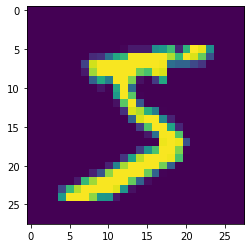

In [21]:
plt.imshow(img[0])

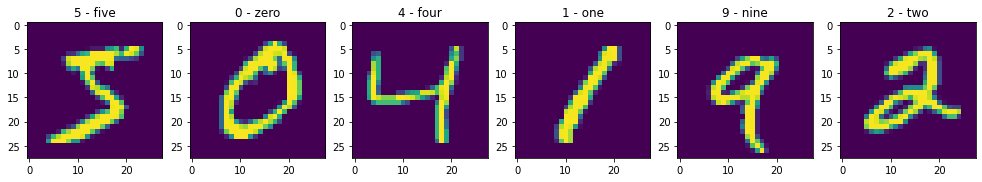

In [22]:
num_images = 6
fig, axs = plt.subplots(ncols=num_images, figsize=(17,5))
for i in range(num_images):
    img, target = mnist_train[i]
    axs[i].imshow(img[0])
    axs[i].set_title(f'{mnist_train.classes[target]}')
    
    

## Model

In [23]:
import torch
from torch import nn

### Encoder

#### Task 1.1: write encoder class with a single hidden layer

Let's start with fully-connected model, i. e. perceptron.
1. As the input, model should take batch of 1d vectors with of 28x28 length (number of pixels)
2. Number of neurons in hidden layer should be an argument of constructor (`__init__` function)
3. The same applies to the number of latent space dimesions 

In [24]:
class Encoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.net = nn.Sequential(
            ... #your code here
        )

    def forward(self, x):
        out = self.net(x)
        return out

Try if it works:

In [26]:
#prepare data
img, target = mnist_train[0]
img = img.reshape(-1)
print('image shape:', img.shape)

image shape: torch.Size([784])


In [27]:
# prepare encoder
hidden_dim = 64
latent_dim = 12
encoder = Encoder_1hl(hidden_dim, latent_dim)

In [28]:
# compute representation in latent space
batch = img.unsqueeze(0) #model operates on batched input. Let's create batch with one sample
print('batch shape:', batch.shape)
with torch.no_grad(): #turn off gradient for this calculation
    z = encoder(batch)
print('output shape:', z.shape)

batch shape: torch.Size([1, 784])
output shape: torch.Size([1, 12])


### Decoder

In [29]:
class Decoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid() # sigmoid function transforms input values (-inf, +inf) to output in range (0, 1)
            )
            

    def forward(self, x):
        x = self.net(x)
        return x

### Autoencoder = Encoder + Decoder

Let's put it all together.

#### Task 1.2: write autoencoder class

Encoder and decoder should have 1 hidden layer each

In [ ]:
class Autoencoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        # your code here
        self.encoder = ...
        self.decoder = ...
            
    def forward(self, x):
        z = self.encoder(x) #embedding
        x_hat = self.decoder(z) # reconstruction
        return x_hat, z # we want to have both the reconstruction and the embedding

In [31]:
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)

In [32]:
batch = img.unsqueeze(0) #model operates on batched input. Let's create batch with one sample
print('batch shape:', batch.shape)
with torch.no_grad(): #turn off gradient
    x_hat, z = autoencoder(batch)
print('output shape:', x_hat.shape)
print('latent shape:', z.shape)

batch shape: torch.Size([1, 784])
output shape: torch.Size([1, 784])
latent shape: torch.Size([1, 12])


So far, the model operates on flatten images. Yet everywhere else we prefer to operate on 1x28x28 images. Let's modify the `forward` function to do the reshaping

#### Task 1.2a: add reshaping

In [ ]:
class Autoencoder_1hl(nn.Module):
    
    # paste your __init__ function here

    def forward(self, x):
        input_shape = x.shape #batch_size, channels, height, width
        x = x.reshape(input_shape[0], -1) # usually: x.view(input_shape[0], -1) does the job as well
        
        # paste the rest of your forward function here
        
        return x.reshape(input_shape)


Try the new model

In [34]:
img, target = mnist_train[0]
batch = img.unsqueeze(0) #model operates on batched input. Let's create batch with one sample
print('batch shape:', batch.shape)
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)
with torch.no_grad(): #turn off gradient
    x_hat, z = autoencoder(batch)
print('output shape:', x_hat.shape)

batch shape: torch.Size([1, 1, 28, 28])
output shape: torch.Size([1, 1, 28, 28])


#### Visualize

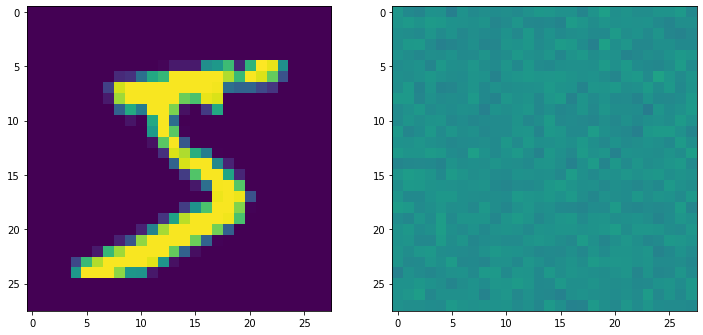

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.imshow(batch[0,0], vmin=0, vmax=1) # why [0,0]? first item from batch, first channel
ax2.imshow(x_hat[0,0], vmin=0, vmax=1)

## Training

Prepare dataloaders

In [36]:
from torch.utils.data import DataLoader

In [38]:
batch_size = 128

In [39]:
mnist_train_dataloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

Closer look on dataloaders

In [40]:
#let't take the first batch
for x, y in mnist_train_dataloader:
  break
# x, y = next(iter(mnist_train_dataloader)) # the first batch can be also taken is this way
print(f'x shape: {x.shape}')
print(f'target shape: {y.shape}')
print(f'target: {y}')

x shape: torch.Size([128, 1, 28, 28])
target shape: torch.Size([128])
target: tensor([7, 0, 5, 0, 1, 3, 5, 1, 2, 7, 6, 7, 0, 3, 8, 3, 6, 6, 4, 5, 0, 0, 4, 4,
        9, 0, 7, 3, 8, 6, 9, 6, 5, 7, 3, 6, 5, 3, 8, 5, 0, 3, 7, 0, 2, 3, 4, 8,
        0, 4, 3, 5, 4, 7, 5, 7, 5, 9, 4, 2, 4, 9, 3, 1, 0, 1, 0, 9, 1, 6, 8, 1,
        3, 0, 2, 7, 7, 8, 6, 4, 9, 0, 0, 6, 8, 9, 6, 7, 2, 6, 8, 2, 2, 9, 0, 9,
        6, 3, 9, 6, 2, 8, 7, 1, 3, 3, 0, 3, 9, 3, 5, 6, 3, 7, 7, 7, 3, 1, 3, 9,
        6, 3, 3, 1, 7, 8, 8, 1])


### Schema of training in PyTorch

Set model, optimizer (which performs optimizing steps) and criterion
```
model = ...
optimizer =  torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = ... #function which computes loss
```

Set device on which computations will be done: 'cpu' or 'cuda' (GPU)
```
device = 'cuda' if torch.cuda.is_available() else 'cpu' # if your machine supports cuda, it wil be used for computation
```

set model to 'train' mode and allocate it to the device
```
model.train().to(device);
```

Schema for single epoch training:
```
for x, y in mnist_train_dataloader:    
    # clear gradient from previous step
    optimizer.zero_grad()
    
    x = x.to(device)
    ... = model(x) # run model
    ... # some processing, if needed 
    loss = ... # calculate batch loss

    # compute accumulated gradients
    loss.backward()

    # perform parameter update based on current gradients
    optimizer.step()
 ```

#### Task 2.1: training loop
write training loop for 2 epochs for autoencoder. Set criterion to mean square root error `nn.MSELoss()`

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # if your machine supports cuda, it wil be used for computation
print(f'device: {device}')
autoencoder.to(device).train();
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss() #the same as nn.functional.mse_loss

device: cuda



Check batches from dataloader

In [42]:
for x, y in mnist_train_dataloader:
  break
# x, y = next(iter(mnist_train_dataloader))
print(x.shape, y.shape)


torch.Size([128, 1, 28, 28]) torch.Size([128])


Check x_hat computation step

In [43]:
x_hat, z = autoencoder(x.to(device))
print(x_hat.shape, z.shape)
print(x_hat.device)

torch.Size([128, 1, 28, 28]) torch.Size([128, 12])
cuda:0


Check loss computation

In [44]:
loss = criterion(x.to(device), x_hat) # note, that x_hat is already at `device`

In [45]:
loss

tensor(0.2317, device='cuda:0', grad_fn=<MseLossBackward0>)

Now, write the training loop:

In [ ]:
num_epochs = 2 #first let's do a short training, to see if the loss go down

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    batch_losses = []

    # your code here

    epoch_loss = np.mean(batch_losses)
    
    print(f'epoch {i_epoch}, loss: {epoch_loss:0.4f}')
    history.append({'loss': epoch_loss})

epoch 0, loss: nan
epoch 1, loss: nan


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Having small loss on training is good, but we really want the model to generalize for unseen samples. Let's calculate loss on test dataset after each epoch

#### Evaluation function
Write function which calculates loss of the model on test dataset

In [47]:
@torch.no_grad() #this decorator disables gradient computation in function. Equivalent to `with torch.no_grad():` inside function. Makes code clearer
def evaluate_model(model, dataloader, criterion):
    losses = []
    model = model.eval()
    for batch in dataloader:  
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder(x)
        loss = criterion(x, x_hat)
        losses.append(loss.item())
    final_loss = np.mean(losses)
    return final_loss

Test if your function works

In [48]:
test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion)
print(f'test loss: {test_loss:0.4f}')

test loss: 0.0285


Now we are ready to implement testset evaluation and do the proper traing of the model. For clarity, let's create a fresh autoencoder

In [108]:
hidden_dim = 64
latent_dim = 12
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)
autoencoder.to(device).train();

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)

In [109]:
num_epochs = 30

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    batch_losses = []

    # your code here

    epoch_loss = np.mean(batch_losses)
    test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion)
    autoencoder.train() # if "evaluate_model" switches the model to 'eval' mode, switch it back 'train'
    print(f'epoch {i_epoch+1}/{num_epochs}, train loss: {epoch_loss:0.4f}, test loss {test_loss:0.4f}')
    history.append({'train loss': epoch_loss, 'test loss': test_loss})
        

epoch 1/30, train loss: 0.0600, test loss 0.0351
epoch 2/30, train loss: 0.0313, test loss 0.0284
epoch 3/30, train loss: 0.0273, test loss 0.0256
epoch 4/30, train loss: 0.0250, test loss 0.0237
epoch 5/30, train loss: 0.0234, test loss 0.0223
epoch 6/30, train loss: 0.0224, test loss 0.0216
epoch 7/30, train loss: 0.0217, test loss 0.0209
epoch 8/30, train loss: 0.0211, test loss 0.0204
epoch 9/30, train loss: 0.0207, test loss 0.0200
epoch 10/30, train loss: 0.0203, test loss 0.0197
epoch 11/30, train loss: 0.0199, test loss 0.0194
epoch 12/30, train loss: 0.0196, test loss 0.0190
epoch 13/30, train loss: 0.0193, test loss 0.0187
epoch 14/30, train loss: 0.0191, test loss 0.0185
epoch 15/30, train loss: 0.0188, test loss 0.0183
epoch 16/30, train loss: 0.0186, test loss 0.0181
epoch 17/30, train loss: 0.0184, test loss 0.0179
epoch 18/30, train loss: 0.0182, test loss 0.0177
epoch 19/30, train loss: 0.0180, test loss 0.0176
epoch 20/30, train loss: 0.0178, test loss 0.0174
epoch 21/

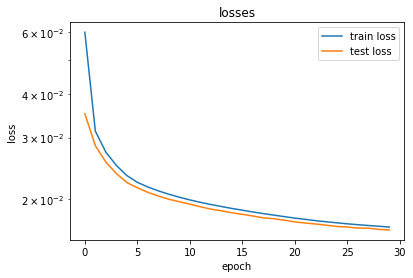

In [110]:
plt.semilogy([entry['train loss'] for entry in history], label='train loss')
plt.semilogy([entry['test loss'] for entry in history], label='test loss')
plt.title('losses');
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

### Save/load model

In [52]:
torch.save(autoencoder, 'autoencoder_dense.pt')
# autoencoder = torch.load('autoencoder_dense.pt')

## Results visualization

For inference on small samples, we can use CPU - it allows to not care about 'cuda' stuff. If the models or images are large, better stay with GPU.

In [111]:
autoencoder.to('cpu').eval();

In [112]:
def reconstruct_image(img, model):
    with torch.no_grad():
        return model(img.unsqueeze(0))[0][0]

In [113]:
img, target = mnist_test[0]
reconstruction = reconstruct_image(img, autoencoder)

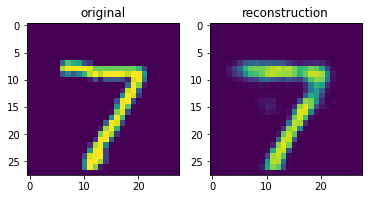

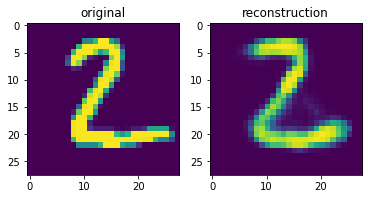

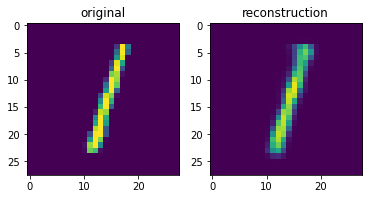

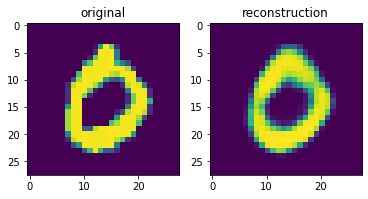

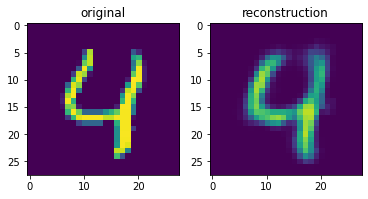

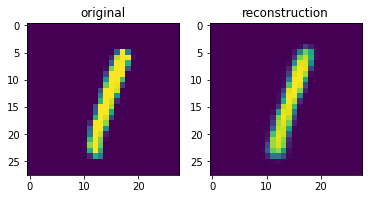

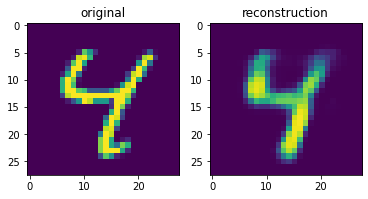

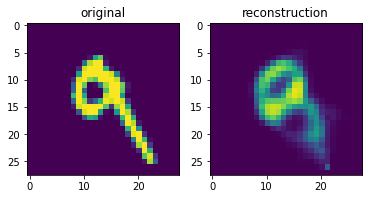

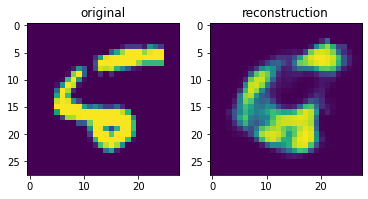

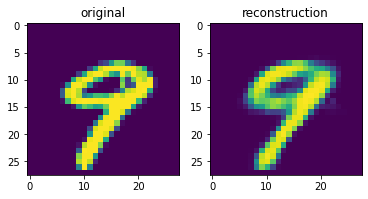

In [114]:
for i in range(10):
    img, target = mnist_test[i]
    reconstruction = reconstruct_image(img, autoencoder)
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title('original')
    axs[1].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[1].set_title('reconstruction')

## Reconstruction errors and outliers
Autoencores may be used to detect outliers. Rare events tend to be poorly reconstructed by the model

In [115]:
reconstruction_errors= []

# criterion gives us single loss for batch. Here the result is a vector of distances, one for each image
# equivalent to nn.functional.mse_loss(x, x_hat, reduction='none').sum(dim=(1,2,3))
def distance_function(x, x_hat):
    return torch.mean((x-x_hat)**2, dim=(1, 2, 3))

autoencoder.to(device);
for x, y in mnist_test_dataloader:
    x = x.to(device)
    x_hat, z = autoencoder(x.to(device))
    errors = distance_function(x, x_hat)
    reconstruction_errors.extend([el.item() for el in errors])

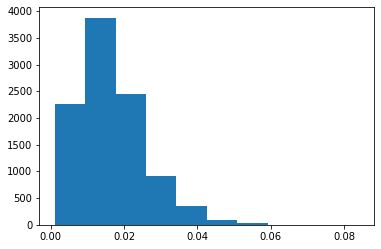

In [116]:
plt.hist(reconstruction_errors);

In [117]:
autoencoder.to('cpu');

In [118]:
labels = mnist_test.targets.numpy() #np.array([x[1] for x in mnist_test])

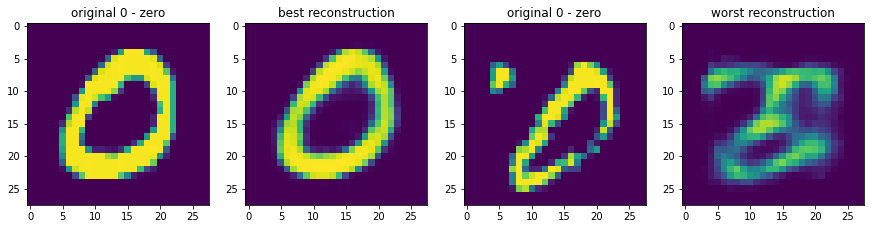

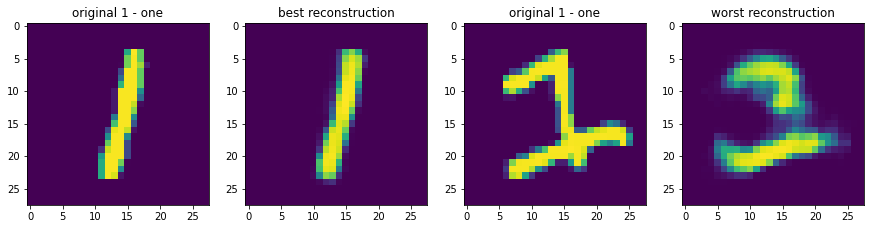

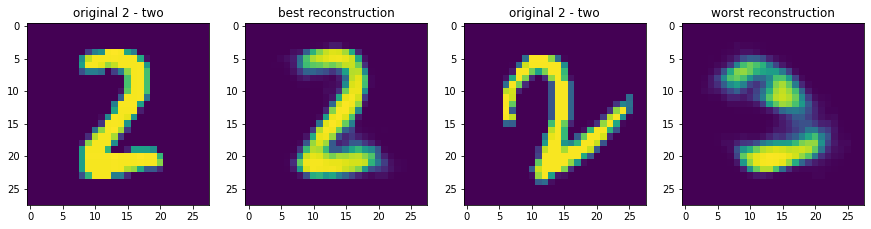

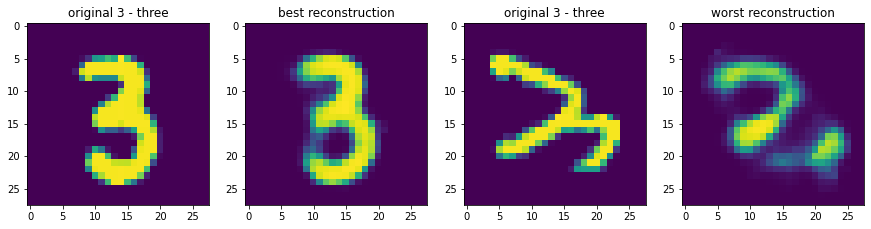

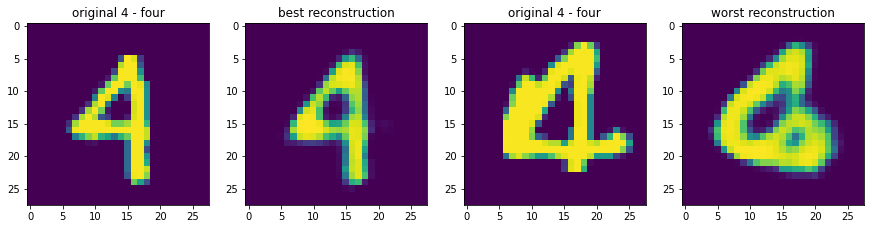

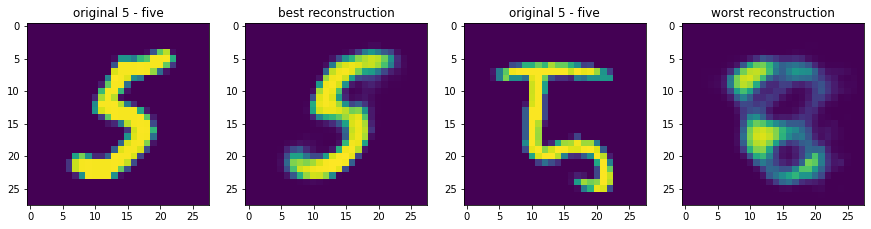

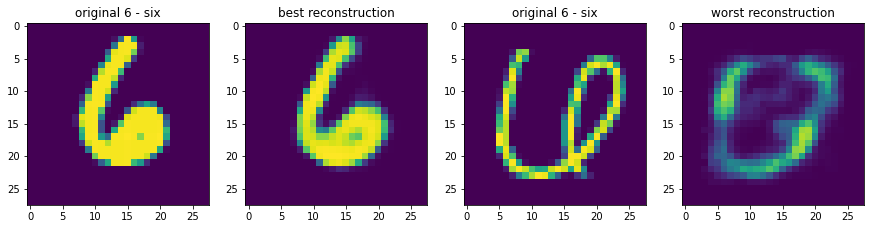

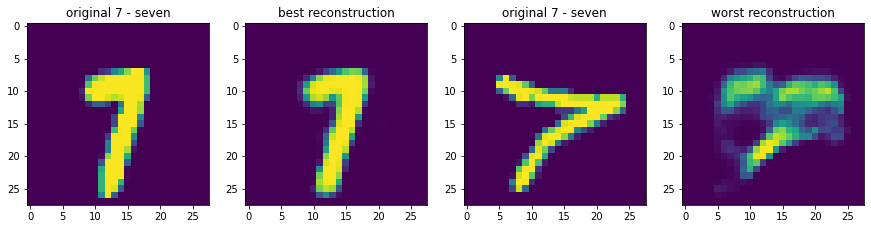

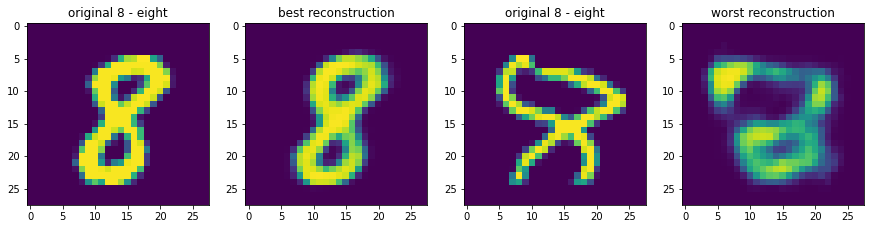

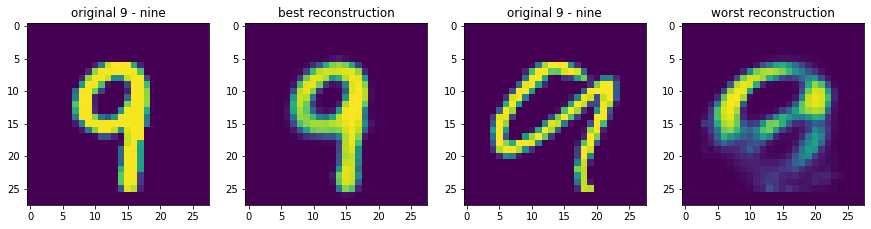

In [119]:
reconstruction_errors = np.array(reconstruction_errors)
for digit in range(10):
    #get indices of the best and the worst reconstruction
    digit_indices = np.where(labels==digit)[0]
    idx_best = digit_indices[np.argmin(reconstruction_errors[digit_indices])]
    idx_worst = digit_indices[np.argmax(reconstruction_errors[digit_indices])]
    
    #create empty figure
    fig, axs = plt.subplots(ncols=4, figsize=(15, 6))
    
    img, target = mnist_test[idx_best]
    reconstruction = reconstruct_image(img, autoencoder)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title(f'original {mnist_test.classes[target]}')
    axs[1].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[1].set_title('best reconstruction')
    
    img, target = mnist_test[idx_worst]
    reconstruction = reconstruct_image(img, autoencoder)
    axs[2].imshow(img[0], vmin=0, vmax=1)
    axs[2].set_title(f'original {mnist_test.classes[target]}')
    axs[3].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[3].set_title('worst reconstruction')

## Task: Anomaly detection

Autoencoders are often used in anomaly detection. In such application, the model is train on 'normal' dataset, learning to  compressed representations typical objects. When feeding with untypical sample, the autoencoder is expected to reconstruct object much worse, therefore the reconstrution error should be much larger. 

Now we will try to distinguish letters from digits. For the letters sample we will use EMNIST is dataset (similar to MNIST, but apart from digits it contains letters). We intend to compare reconstruction errors on digits and letters.

In [62]:
from torchvision.datasets import EMNIST

In [63]:
emnist_test = EMNIST(DATASETS_PATH, split='letters', train=False, download=True, transform=transforms.ToTensor());
print(emnist_test.classes)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw
['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Let's look at some letter examples:

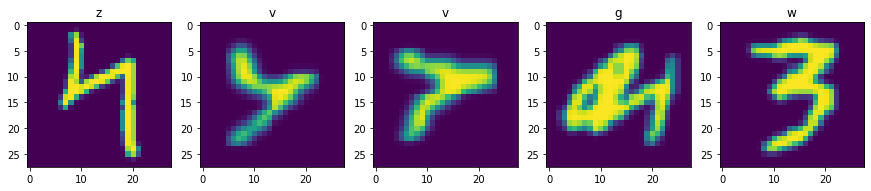

In [64]:
fig, axs = plt.subplots(ncols=5, figsize=(15,5))
for i, idx in enumerate(np.random.choice(np.arange(len(emnist_test)), 5)):
    img, target = emnist_test[idx]
    axs[i].imshow(img[0], vmin=0, vmax=1)
    axs[i].set_title(emnist_test.classes[target]);

As you, that the letters are rotated and mirrored. For out purpose it doesn't matter. If you care, use `img[0].T` for displaying or change dataset transform to `transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda img: img.transpose(1, 2))])`

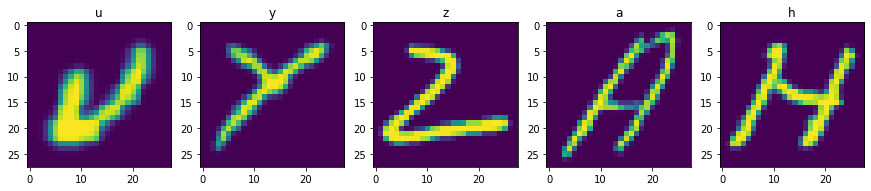

In [65]:
fig, axs = plt.subplots(ncols=5, figsize=(15,5))
for i, idx in enumerate(np.random.choice(np.arange(len(emnist_test)), 5)):
    img, target = emnist_test[idx]
    axs[i].imshow(img[0].T, vmin=0, vmax=1)
    axs[i].set_title(emnist_test.classes[target]);

In [66]:
emnist_test = EMNIST(DATASETS_PATH, split='letters', train=False, download=True, 
                     transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda img: img.transpose(1, 2))])
                     );

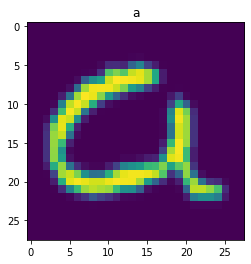

In [67]:
img, target = emnist_test[2]
plt.imshow(img[0], vmin=0, vmax=1)
plt.title(emnist_test.classes[target]);

#### Calculate reconstruction error
Compute reconstruction errors for 1000 digits and 1000 letters.

In [205]:
# generate dataset indices for digits and letters
digit_indices = np.random.choice(np.arange(len(mnist_test)), 1000)
letter_indices = np.random.choice(np.arange(len(emnist_test)), 1000)

In [120]:
# set autoencoder to eval mode and set the device
autoencoder = autoencoder.eval().to(device)

In [95]:
criterion = nn.MSELoss()
def calc_reconstruction_error(x, model):
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        x_hat, z = model(x)
        reconstruction_error = criterion(x, x_hat).item()
    return reconstruction_error

# #you can also use numpy
# @torch.no_grad()
# def calc_reconstruction_error(x, model):
#     x_hat = model(x.unsqueeze(0).to(device))[0]
#     reconstruction_error = np.mean((x_hat.cpu().numpy() - x.cpu().numpy())**2)
#     return reconstruction_error

In [121]:
digits_reconstruction_errors= []
autoencoder = autoencoder.eval().to(device)
for idx in digit_indices:
    img, _ = mnist_test[idx]
    reconstruction_error = calc_reconstruction_error(img, autoencoder)
    digits_reconstruction_errors.append(reconstruction_error)    

In [122]:
letters_reconstruction_errors= []
autoencoder = autoencoder.eval().to(device)
for idx in letter_indices:
    img, _ = emnist_test[idx]
    reconstruction_error = calc_reconstruction_error(img, autoencoder)
    letters_reconstruction_errors.append(reconstruction_error)    

Visualize the results:

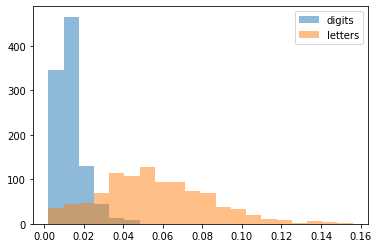

In [123]:
bins=np.histogram(np.hstack((digits_reconstruction_errors,letters_reconstruction_errors)), bins=20)[1]
plt.hist(digits_reconstruction_errors, bins, alpha=0.5, label='digits');
plt.hist(letters_reconstruction_errors, bins, alpha=0.5, label='letters');
plt.legend();

Short analysis of result

In [74]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_auc_score

In [124]:
df = pd.DataFrame([{'class': 0, 'error': x} for x in digits_reconstruction_errors] + [{'class': 1, 'error': x} for x in letters_reconstruction_errors])
df.sample(10)

,class,error
970,0,0.014716
999,0,0.018695
348,0,0.007912
22,0,0.014364
271,0,0.020345
1261,1,0.076194
369,0,0.011839
1759,1,0.048256
1047,1,0.070811
1633,1,0.035263


In [125]:
precision, recall, thresholds = precision_recall_curve(df['class'], df['error'])
rocauc = roc_auc_score(df['class'], df['error'])

Text(0.5, 1.0, 'Area under curve: 0.938')

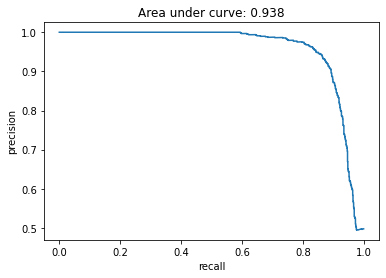

In [126]:
plt.plot(recall, precision)
plt.xlabel('recall');
plt.ylabel('precision');
plt.title(f'Area under curve: {rocauc:0.3f}')

## Task: Few shot classification

In [127]:
@torch.no_grad()
def encode_image(img, model, device='cpu'):
  x_hat, z = model(img.unsqueeze(0).to(device))
  return z[0].to('cpu') # "[0]" beacuse 1st item of batch

In [128]:
from sklearn.neighbors import KNeighborsClassifier

In [173]:
N_prototypes = 5

In [174]:
classes_indices = {}
for label in np.arange(len(mnist_train.classes)):
  classes_indices[label] = np.random.choice(np.where(mnist_train.targets==label)[0], size=N_prototypes, replace=False)

prepare training data

In [175]:
X_train = []
y_train = []
for label, class_indices in classes_indices.items():
  for idx in class_indices:
    img, _ = mnist_train[idx]
    X_train.append(encode_image(img, autoencoder, device).numpy())
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [176]:
X_test = []
y_test = []
for idx in range(len(mnist_test)):
  img, label = mnist_test[idx]
  X_test.append(encode_image(img, autoencoder, device).numpy())
  y_test.append(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [177]:
knn_cls = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [178]:
knn_cls.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [179]:
y_pred = knn_cls.predict(X_test)

Accuracy:

In [180]:
np.mean(y_pred == y_test)

0.6903

In [181]:
from sklearn.metrics import ConfusionMatrixDisplay

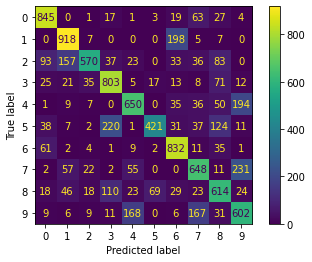

In [182]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### What about raw images?

The same can be done in pixel space (without encoding).
Drawbacks:
- larger data size
- lower accuracy

In [183]:
X_train_pix = []
for label, class_indices in classes_indices.items():
  for idx in class_indices:
    img, _ = mnist_train[idx]
    X_train_pix.append(img.detach().numpy().flatten())

X_train_pix = np.array(X_train_pix)

X_test_pix = []
for idx in range(len(mnist_test)):
  img, label = mnist_test[idx]
  X_test_pix.append(img.detach().numpy().flatten())

X_test_pix = np.array(X_test_pix)

In [184]:
knn_cls_pix = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_cls_pix.fit(X_train_pix, y_train)
y_pred_pix = knn_cls_pix.predict(X_test_pix)

In [185]:
np.mean(y_pred_pix == y_test)

0.6061

### Transforms

# Visualize latent space

In [206]:
len(digit_indices)

1000

In [207]:
representations_digits = []
labels_digits = []

with torch.no_grad():
  for idx in digit_indices:
    img, label = mnist_test[idx]
    x = img.unsqueeze(0).to(device)
    x_hat, z = autoencoder(x)
    representations_digits.append(z[0].cpu().numpy())
    labels_digits.append(label)

representations_digits = np.array(representations_digits)
labels_digits = np.array(labels_digits)

In [212]:
representations_letters = []
labels_letters = []

with torch.no_grad():
  for idx in letter_indices:
    img, label = emnist_test[idx]
    x = img.unsqueeze(0).to(device)
    x_hat, z = autoencoder(x)
    representations_letters.append(z[0].cpu().numpy())
    labels_letters.append(label)

representations_letters = np.array(representations_letters)
labels_letters = np.array(labels_letters)

In [209]:
from sklearn.manifold import TSNE

"t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results"

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

You may try also [UMAP](https://umap-learn.readthedocs.io/en/latest/), which is faster.

Both often require parameter tuning to obtain nice visualizations.

In [213]:
X_embedded = TSNE(n_components=2).fit_transform(np.concatenate((representations_digits, representations_letters)))
digits_embedded = X_embedded[:len(representations_digits)]
letters_embedded = X_embedded[len(representations_digits):]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


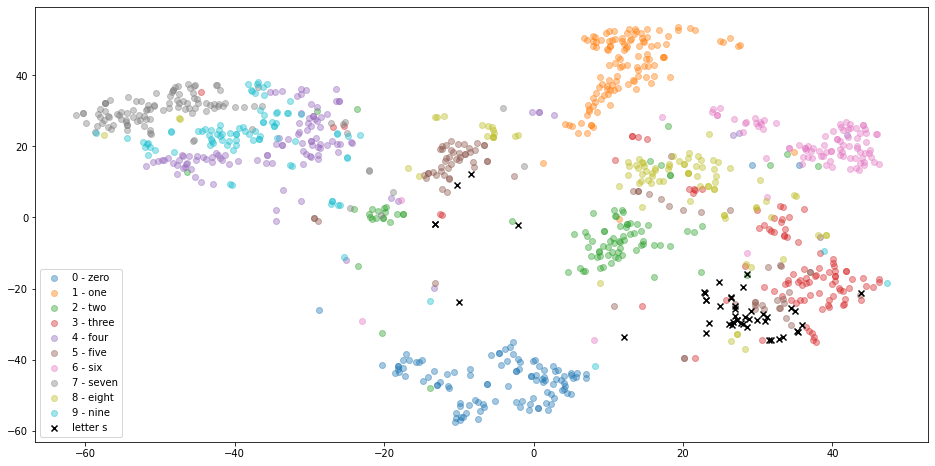

In [252]:
fig, ax = plt.subplots(figsize=(16,8))
for i, label in enumerate(sorted(set(labels_digits))):
    X_cat = digits_embedded[labels_digits==i]
    ax.scatter(X_cat[:,0], X_cat[:,1], label=mnist_test.classes[label], c=f'C{i}', alpha=0.4)

letter = 's'
letter_index = emnist_test.classes.index(letter)
X_cat = letters_embedded[labels_letters==letter_index]
ax.scatter(X_cat[:,0], X_cat[:,1], label=f'letter {letter}', c='k', marker='x')

plt.legend()


# Denoising autoencoders

![denoising](https://miro.medium.com/max/5160/1*SxwRp9i23OM0Up4sEze1QQ@2x.png)
Source: https://www.kaggle.com/tarunkr/autoencoder-denoising-image-mnist-cifar10

## Transforms

In [228]:
class SaltPepper:
    def __init__(self, noise):
        self.noise = noise
    
    def __call__(self, img_or_batch):
        if img_or_batch.ndim == 3:
            is_image=True
            img_or_batch = img_or_batch.unsqueeze(0) # produce "batch" of length 1
        else:
            is_image=False
        
        batch_out = img_or_batch.clone()
    
        N_pixels = batch_out.shape[0] * batch_out.shape[2] * batch_out.shape[3]
        # randomly sample indices for salt and pepper
        indices_salt = np.random.choice(np.arange(N_pixels), int(0.5*self.noise*N_pixels))
        indices_pepper = np.random.choice(np.arange(N_pixels), int(0.5*self.noise*N_pixels))
        # apply salt and pepper
        batch_out[np.unravel_index(indices_salt, batch_out.shape)] = 0.0
        batch_out[np.unravel_index(indices_pepper, batch_out.shape)] = 1.0
        
        if is_image:
            return batch_out.squeeze(0) # return image shape
    
        return batch_out
  
class MaskGenerator:
  def __init__(self, scale=4, noise=0.4, fill_value=0.5):
      self.scale = scale
      self.noise = noise
      self.fill_value = fill_value
  
  def __call__(self, img_or_batch):
      if img_or_batch.ndim == 3:
          is_image=True
          img_or_batch = img_or_batch.unsqueeze(0) # produce "batch" of length 1
      else:
          is_image=False
      
      batch_out = img_or_batch.clone()
      batch_size, channels, height, width = batch_out.shape
      
      # be sure that scale if divisor of both height and width
      assert height%self.scale == 0 and width%self.scale == 0
              
      # get random mask
      N_pixels = batch_size * height//self.scale * width//self.scale
      indices_mask = np.random.rand(N_pixels).reshape((batch_out.shape[0], 1, batch_out.shape[2]//self.scale, batch_out.shape[3]//self.scale)) < self.noise
      indices_mask = indices_mask.repeat(self.scale, axis=2).repeat(self.scale, axis=3)
      indices_mask = torch.from_numpy(indices_mask).float().to(img_or_batch.device)

      # apply mask
      batch_out = (1-indices_mask)*batch_out + indices_mask*self.fill_value
      
      if is_image:
          return batch_out.squeeze(0) # return image shape
  
      return batch_out

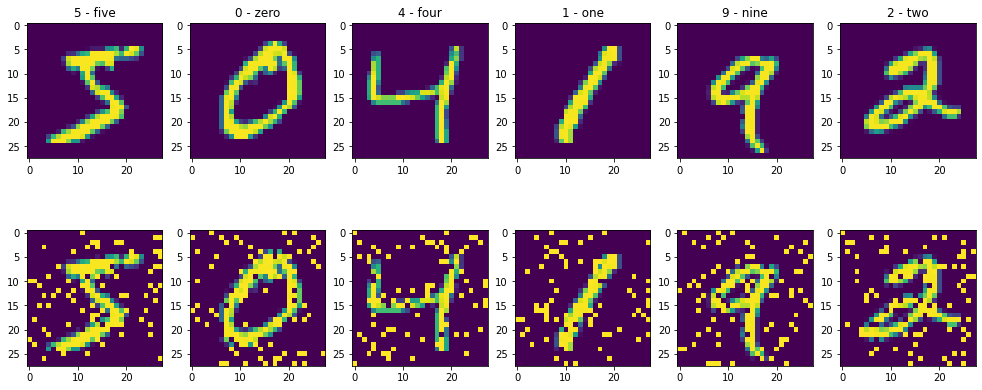

In [229]:
noise_level = 0.2
salt_pepper_transform = SaltPepper(noise_level)

num_images = 6
fig, axs = plt.subplots(ncols=num_images, nrows=2, figsize=(17,7))
for i in range(num_images):
    img, target = mnist_train[i]
    axs[0][i].imshow(img[0])
    axs[0][i].set_title(f'{mnist_train.classes[target]}')
    axs[1][i].imshow(salt_pepper_transform(img)[0])

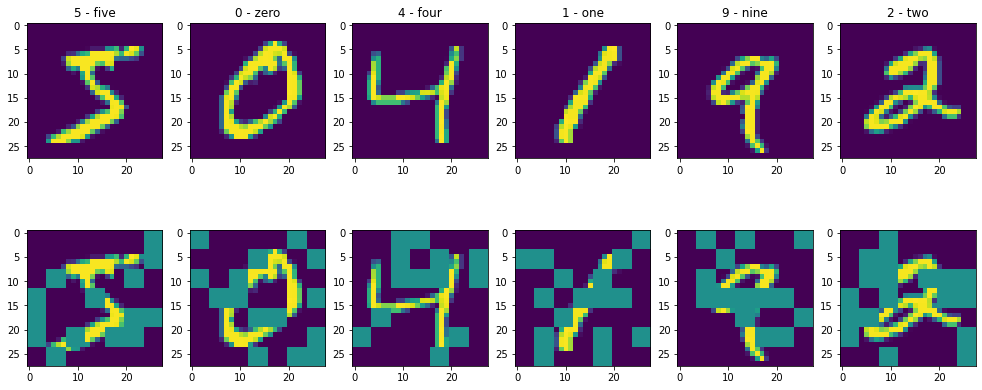

In [230]:
noise_level = 0.3
mask_transform = MaskGenerator(scale=4, noise=noise_level, fill_value=0.5)

num_images = 6
fig, axs = plt.subplots(ncols=num_images, nrows=2, figsize=(17,7))
for i in range(num_images):
    img, target = mnist_train[i]
    axs[0][i].imshow(img[0])
    axs[0][i].set_title(f'{mnist_train.classes[target]}')
    axs[1][i].imshow(mask_transform(img)[0])
    

## Training

In [243]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion, distortion=None, device=device):
    losses = []
    model = model.eval()
    for batch in dataloader:  
        x, y = batch
        x = x.to(device)
        if distortion is None:
          x_distorted = x
        else:
          x_distorted = distortion(x)
        x_hat, z = model(x_distorted)
        loss = criterion(x, x_hat)
        losses.append(loss.item())
    final_loss = np.mean(losses)
    return final_loss

In [246]:
distortion = MaskGenerator(noise=noise_level) #SaltPepper(noise_level)

hidden_dim = 64
latent_dim = 12
autoencoder = Autoencoder_1hl(hidden_dim, latent_dim)
autoencoder.to(device).train();

optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3)

In [247]:
num_epochs = 20 #if you have time, train as long as as test lost stop decreasing

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder(distortion(x))
        loss = criterion(x, x_hat)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion, distortion)
    autoencoder.train() # if "evaluate_model" switches the model to 'eval' mode, switch it back 'train'
    print(f'epoch {i_epoch}, train loss: {epoch_loss:0.4f}, test loss {test_loss:0.4f}')
    history.append({'train loss': epoch_loss, 'test loss': test_loss})

epoch 0, train loss: 0.0595, test loss 0.0415
epoch 1, train loss: 0.0377, test loss 0.0343
epoch 2, train loss: 0.0334, test loss 0.0317
epoch 3, train loss: 0.0314, test loss 0.0301
epoch 4, train loss: 0.0301, test loss 0.0291
epoch 5, train loss: 0.0291, test loss 0.0283
epoch 6, train loss: 0.0284, test loss 0.0276
epoch 7, train loss: 0.0279, test loss 0.0272
epoch 8, train loss: 0.0274, test loss 0.0267
epoch 9, train loss: 0.0270, test loss 0.0263
epoch 10, train loss: 0.0265, test loss 0.0258
epoch 11, train loss: 0.0262, test loss 0.0257
epoch 12, train loss: 0.0259, test loss 0.0253
epoch 13, train loss: 0.0256, test loss 0.0252
epoch 14, train loss: 0.0254, test loss 0.0248
epoch 15, train loss: 0.0252, test loss 0.0245
epoch 16, train loss: 0.0250, test loss 0.0245
epoch 17, train loss: 0.0248, test loss 0.0242
epoch 18, train loss: 0.0246, test loss 0.0242
epoch 19, train loss: 0.0244, test loss 0.0239


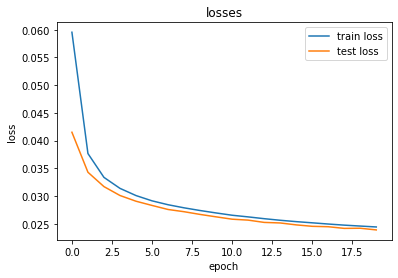

In [248]:
plt.plot([entry['train loss'] for entry in history], label='train loss') #plt.semilogx for log scale
plt.plot([entry['test loss'] for entry in history], label='test loss')
plt.title('losses');
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [249]:
autoencoder.to('cpu').eval();

In [250]:
img, target = mnist_test[0]
img_distorted = distortion(img.unsqueeze(0)).squeeze(0)
reconstruction = reconstruct_image(img_distorted, autoencoder)

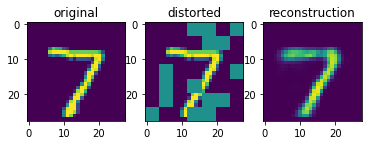

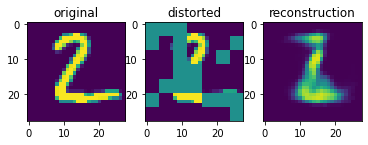

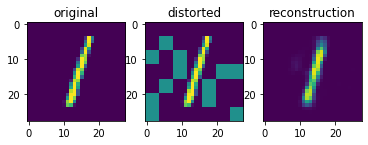

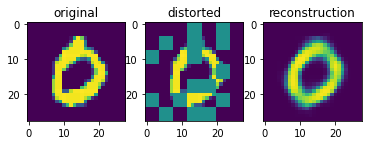

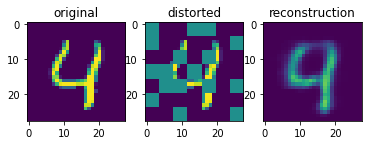

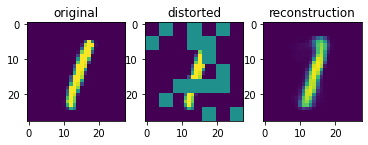

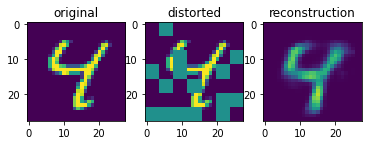

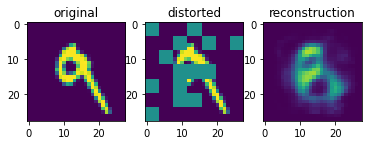

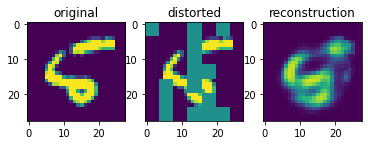

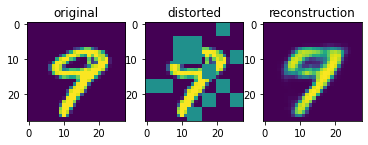

In [251]:
for i in range(10):
    img, target = mnist_test[i]
    img_distorted = distortion(img.unsqueeze(0)).squeeze(0)
    reconstruction = reconstruct_image(img_distorted, autoencoder)
    fig, axs = plt.subplots(ncols=3)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title('original')
    axs[1].imshow(img_distorted[0], vmin=0, vmax=1)
    axs[1].set_title('distorted')
    axs[2].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[2].set_title('reconstruction')

# Different architectures

In [ ]:
class ConvAutoencoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10 # here and bellow numbers correspods to dimensions: b (batch size), channels, height, width
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
    
    @torch.no_grad()
    def encode_image(self, x):
        return self.encoder(x.unsqueeze(0))[0].view(1,-1)
        

In [ ]:
class ConvAutoencoder2(nn.Module):
    """from https://github.com/syorami/Autoencoders-Variants/blob/master/conv_autoencoder.py"""
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z.reshape(()))
        return x_hat, z
    
    @torch.no_grad()
    def encode_image(self, x):
        return self.encoder(x.unsqueeze(0))[0].view(1,-1)

In [ ]:
"""from https://github.com/eifuentes/swae-pytorch/blob/master/swae/models/mnist.py"""

class MNISTEncoder(nn.Module):
    """ MNIST Encoder from Original Paper's Keras based Implementation.
        Args:
            init_num_filters (int): initial number of filters from encoder image channels
            lrelu_slope (float): positive number indicating LeakyReLU negative slope
            inter_fc_dim (int): intermediate fully connected dimensionality prior to embedding layer
            embedding_dim (int): embedding dimensionality
    """
    def __init__(self, init_num_filters=16, lrelu_slope=0.2, inter_fc_dim=128, embedding_dim=2):
        super(MNISTEncoder, self).__init__()

        self.init_num_filters_ = init_num_filters
        self.lrelu_slope_ = lrelu_slope
        self.inter_fc_dim_ = inter_fc_dim
        self.embedding_dim_ = embedding_dim

        self.features = nn.Sequential(
            nn.Conv2d(1, self.init_num_filters_ * 1, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 1, self.init_num_filters_ * 1, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.AvgPool2d(kernel_size=2, padding=0),
            nn.Conv2d(self.init_num_filters_ * 1, self.init_num_filters_ * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 2, self.init_num_filters_ * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.AvgPool2d(kernel_size=2, padding=0),
            nn.Conv2d(self.init_num_filters_ * 2, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.AvgPool2d(kernel_size=2, padding=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(self.init_num_filters_ * 4 * 4 * 4, self.inter_fc_dim_),
            nn.ReLU(inplace=True),
            nn.Linear(self.inter_fc_dim_, self.embedding_dim_)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.init_num_filters_ * 4 * 4 * 4)
        x = self.fc(x)
        return x


class MNISTDecoder(nn.Module):
    """ MNIST Decoder from Original Paper's Keras based Implementation.
        Args:
            init_num_filters (int): initial number of filters from encoder image channels
            lrelu_slope (float): positive number indicating LeakyReLU negative slope
            inter_fc_dim (int): intermediate fully connected dimensionality prior to embedding layer
            embedding_dim (int): embedding dimensionality
    """
    def __init__(self, init_num_filters=16, lrelu_slope=0.2, inter_fc_dim=128, embedding_dim=2):
        super(MNISTDecoder, self).__init__()

        self.init_num_filters_ = init_num_filters
        self.lrelu_slope_ = lrelu_slope
        self.inter_fc_dim_ = inter_fc_dim
        self.embedding_dim_ = embedding_dim

        self.fc = nn.Sequential(
            nn.Linear(self.embedding_dim_, self.inter_fc_dim_),
            nn.Linear(self.inter_fc_dim_, self.init_num_filters_ * 4 * 4 * 4),
            nn.ReLU(inplace=True)
        )

        self.features = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=0),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 4, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.init_num_filters_ * 4, self.init_num_filters_ * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 2, self.init_num_filters_ * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(self.lrelu_slope_, inplace=True),

            nn.Conv2d(self.init_num_filters_ * 2, 1, kernel_size=3, padding=1)
        )

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 4 * self.init_num_filters_, 4, 4)
        z = self.features(z)
        return torch.sigmoid(z)


class MNISTAutoencoder(nn.Module):
    """ MNIST Autoencoder from Original Paper's Keras based Implementation.
        Args:
            init_num_filters (int): initial number of filters from encoder image channels
            lrelu_slope (float): positive number indicating LeakyReLU negative slope
            inter_fc_dim (int): intermediate fully connected dimensionality prior to embedding layer
            embedding_dim (int): embedding dimensionality
    """
    def __init__(self, init_num_filters=16, lrelu_slope=0.2, inter_fc_dim=128, embedding_dim=2):
        super(MNISTAutoencoder, self).__init__()

        self.init_num_filters_ = init_num_filters
        self.lrelu_slope_ = lrelu_slope
        self.inter_fc_dim_ = inter_fc_dim
        self.embedding_dim_ = embedding_dim

        self.encoder = MNISTEncoder(init_num_filters, lrelu_slope, inter_fc_dim, embedding_dim)
        self.decoder = MNISTDecoder(init_num_filters, lrelu_slope, inter_fc_dim, embedding_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z


In [ ]:
"""from https://github.com/syorami/Autoencoders-Variants/blob/master/simple_autoencoder.py"""
class FCAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        input_shape = x.shape #batch_size, channels, height, width
        x = x.reshape(input_shape[0], -1)
        z = self.encoder(x)
        x_hat = self.decoder(z) 
        return x_hat.reshape(input_shape), z

### Try it:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')
autoencoder = FCAutoencoder()
autoencoder.to(device).train();
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-3) #decrease learning rate if the model converges to a bad result
criterion = nn.MSELoss() 

device: cuda


In [ ]:
num_epochs = 20 #train longer

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder(x)
        loss = criterion(x, x_hat)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    test_loss = evaluate_model(autoencoder, mnist_test_dataloader, criterion)
    autoencoder.train() # if "evaluate_model" switches the model to 'eval' mode, switch it back 'train'
    print(f'epoch {i_epoch+1}/{num_epochs}, train loss: {epoch_loss:0.4f}, test loss {test_loss:0.4f}')
    history.append({'train loss': epoch_loss, 'test loss': test_loss})
        

epoch 1/20, train loss: 0.0759, test loss 0.0373
epoch 2/20, train loss: 0.0349, test loss 0.0316
epoch 3/20, train loss: 0.0317, test loss 0.0298
epoch 4/20, train loss: 0.0303, test loss 0.0287
epoch 5/20, train loss: 0.0294, test loss 0.0279
epoch 6/20, train loss: 0.0288, test loss 0.0274
epoch 7/20, train loss: 0.0283, test loss 0.0270
epoch 8/20, train loss: 0.0280, test loss 0.0267
epoch 9/20, train loss: 0.0277, test loss 0.0264
epoch 10/20, train loss: 0.0275, test loss 0.0262
epoch 11/20, train loss: 0.0273, test loss 0.0261
epoch 12/20, train loss: 0.0271, test loss 0.0259
epoch 13/20, train loss: 0.0270, test loss 0.0259
epoch 14/20, train loss: 0.0269, test loss 0.0257
epoch 15/20, train loss: 0.0268, test loss 0.0256
epoch 16/20, train loss: 0.0267, test loss 0.0255
epoch 17/20, train loss: 0.0266, test loss 0.0254
epoch 18/20, train loss: 0.0265, test loss 0.0254
epoch 19/20, train loss: 0.0265, test loss 0.0253
epoch 20/20, train loss: 0.0264, test loss 0.0253


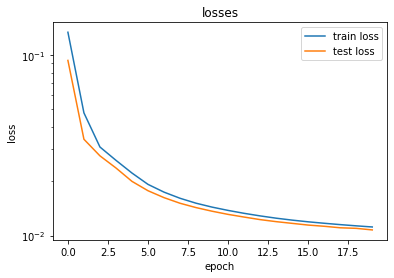

In [ ]:
plt.semilogy([entry['train loss'] for entry in history], label='train loss')
plt.semilogy([entry['test loss'] for entry in history], label='test loss')
plt.title('losses');
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [ ]:
autoencoder.to('cpu').eval();

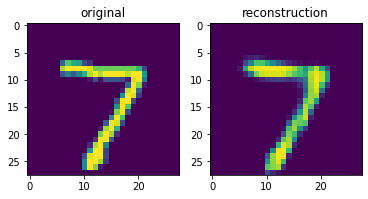

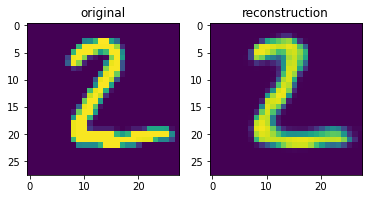

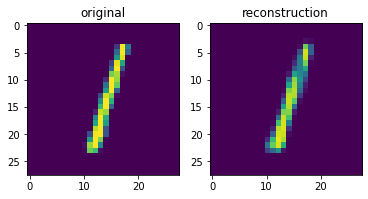

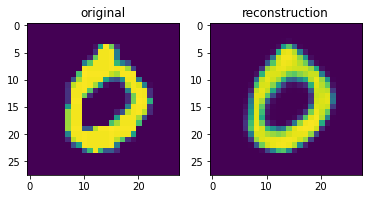

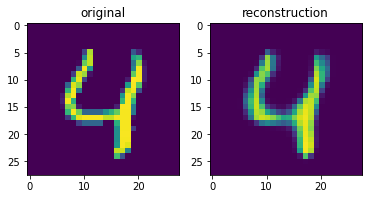

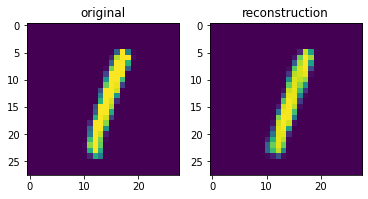

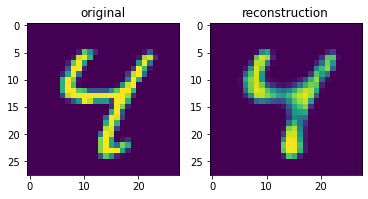

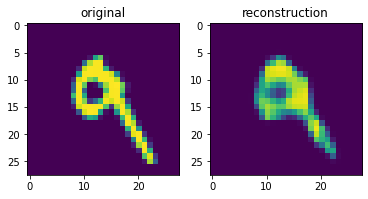

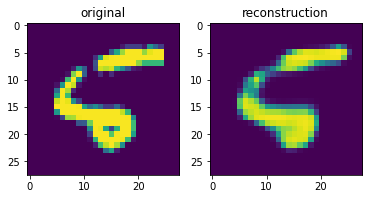

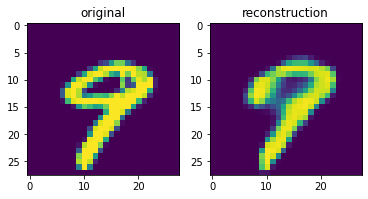

In [ ]:
for i in range(10):
    img, target = mnist_test[i]
    reconstruction = reconstruct_image(img, autoencoder)
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(img[0], vmin=0, vmax=1)
    axs[0].set_title('original')
    axs[1].imshow(reconstruction[0], vmin=0, vmax=1)
    axs[1].set_title('reconstruction')

# Solutions

#### Task 1.1: write encoder class with a single hidden layer

In [ ]:
class Encoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            )

    def forward(self, x):
        x = self.net(x)
        return x

#### Task 1.2: write autoencoder class

In [ ]:
class Autoencoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()

        self.encoder = Encoder_1hl(hidden_dim, latent_dim)
        self.decoder = Decoder_1hl(hidden_dim, latent_dim)
            
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z) 
        return x_hat, z

With input reshaping:

In [ ]:
class Autoencoder_1hl(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        """
        hidden_dim: number of neurons in the hidden layer
        latent_dim: number of latent space dimensions
        """
        super().__init__()

        self.encoder = Encoder_1hl(hidden_dim, latent_dim)
        self.decoder = Decoder_1hl(hidden_dim, latent_dim)
            
    def forward(self, x):
        input_shape = x.shape #batch_size, channels, height, width
        x = x.reshape(input_shape[0], -1)
        z = self.encoder(x)
        x_hat = self.decoder(z) 
        return x_hat.reshape(input_shape), z

#### Task 2.1: training loop

In [ ]:
num_epochs = 2

history = [] #save losses from each epoch
for i_epoch in range(num_epochs):
    epoch_losses = []
    for batch in mnist_train_dataloader:
         # clear gradient from previous step
        optimizer.zero_grad()
        
        x, y = batch
        x = x.to(device)
        x_hat, z = autoencoder(x)
        loss = criterion(x, x_hat)
        
        # compute accumulated gradients
        loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # save loss
        epoch_losses.append(loss.item()) #'item()' gets number from tensor. Similarly 'numpy()' returns numpy array copy of the tensor
        
        
    epoch_loss = np.mean(epoch_losses)
    print(f'epoch {i_epoch}, loss: {epoch_loss:0.4f}')
    history.append({'loss': epoch_loss})
        

#### Task 3.1: calculate reconstruction error

In [ ]:
criterion = nn.MSELoss()
def calc_reconstruction_error(x, model):
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        x_hat, z = model(x)
        reconstruction_error = criterion(x, x_hat).item()
    return reconstruction_error

# #you can also use numpy
# @torch.no_grad()
# def calc_reconstruction_error(x, model):
#     x_hat = model(x.unsqueeze(0).to(device))[0]
#     reconstruction_error = np.mean((x_hat.cpu().numpy() - x.cpu().numpy())**2)
#     return reconstruction_error
   

In [ ]:
digits_reconstruction_errors= []
autoencoder = autoencoder.eval().to(device)
for idx in digit_indices:
    img, _ = mnist_test[idx]
    reconstruction_error = calc_reconstruction_error(img, autoencoder)
    digits_reconstruction_errors.append(reconstruction_error) 

In [ ]:
letters_reconstruction_errors= []
autoencoder = autoencoder.eval().to(device)
for idx in letter_indices:
    img, _ = emnist_test[idx]
    reconstruction_error = calc_reconstruction_error(img, autoencoder)
    letters_reconstruction_errors.append(reconstruction_error)    